# Introduction
IndoNLU saat ini memiliki 12 aplikasi NLU, seperti analisis sentimen, ekstraksi term, ekstraksi kata kunci (keyword), dll. IndoNLU menyediakan pre-trained model IndoBERT yang dilatih dengan kumpulan teks berisi sekitar 4 miliar kata (Indo4B). IndoNLU juga menyediakan akses ke kumpulan data pra-pelatihan Indo4B Dataset yang berukuran lebih dari 20GB data teks.

[For further info](https://github.com/IndoNLP/indonlu)

# Library

In [4]:
!pip install torch torchvision
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00


# Preparation

In [5]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 500 (delta 115), reused 142 (delta 111), pack-reused 316
Receiving objects: 100% (500/500), 9.45 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [6]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

Selanjutnya, definisikan fungsi umum sebagai berikut.

- set_seed : Mengatur dan menetapkan random seed.
- count_param : Menghitung jumlah parameter dalam model
- get_lr : Mengatur learning rate
- metrics_to_string : Mengonversi metriks ke dalam string

In [7]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [8]:
# Set random seed
set_seed(19072021)
# Anda bebas mengatur random seed asalkan dalam bentuk angka atau integer.
# Tujuan mengatur random seed adalah agar model memberikan hasil yang sama setiap kali kita melakukan proses training.
# Untuk memudahkan, set random_seed dengan tanggal saat kita menjalankan kode tersebut.

# Konfigurasi dan Load Pre-trained Model

In [9]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
count_param(model)
# Hasilnya, ada 124.443.651 parameter dalam pre-trained model IndoBert-base-p1.

124443651

# Persiapan Dataset

In [12]:
train_dataset_path = '/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv'
valid_dataset_path = '/content/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv'
test_dataset_path = '/content/indonlu/dataset/smsa_doc-sentiment-prosa/test_preprocess_masked_label.tsv'

Untuk menunjukan bagaimana cara mengimplementasikan Dataset dan DataLoader di PyTorch, kita akan melihat lebih dalam pada kelas DocumentSentimentDataset dan DocumentSentimentDataLoader yang disediakan oleh IndoNLU. Anda dapat mengaksesnya di tautan berikut: data_utils.py.

In [14]:
# class DocumentSentimentDataset(Dataset):
#     # Static constant variable
#     LABEL2INDEX = {'positive': 0, 'neutral': 1, 'negative': 2} # Map dari label string ke index
#     INDEX2LABEL = {0: 'positive', 1: 'neutral', 2: 'negative'} # Map dari Index ke label string
#     NUM_LABELS = 3 # Jumlah label

#     def load_dataset(self, path):
#         df = pd.read_csv(path, sep=’\t’, header=None) # Baca tsv file dengan pandas
#         df.columns = ['text','sentiment'] # Berikan nama pada kolom tabel
#         df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab]) # Konversi string label ke index
#         return df

#     def __init__(self, dataset_path, tokenizer, *args, **kwargs):
#         self.data = self.load_dataset(dataset_path) # Load tsv file

#         # Assign tokenizer, disini kita menggunakan tokenizer subword dari HuggingFace
#         self.tokenizer = tokenizer

#     def __getitem__(self, index):
#         data = self.data.loc[index,:] # Ambil data pada baris tertentu dari tabel
#         text, sentiment = data['text'], data['sentiment'] # Ambil nilai text dan sentiment
#         subwords = self.tokenizer.encode(text) # Tokenisasi text menjadi subword

#     # Return numpy array dari subwords dan label
#         return np.array(subwords), np.array(sentiment), data['text']

#     def __len__(self):
#         return len(self.data)  # Return panjang dari dataset

Sedangkan, untuk kelas SentimentDataLoader adalah sebagai berikut.

In [15]:
# class DocumentSentimentDataLoader(DataLoader):
#     def __init__(self, max_seq_len=512, *args, **kwargs):
#         super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
#         self.max_seq_len = max_seq_len # Assign batas maksimum subword
#         self.collate_fn = self._collate_fn # Assign fungsi collate_fn dengan fungsi yang kita definisikan

#     def _collate_fn(self, batch):
#         batch_size = len(batch) # Ambil batch size
#         max_seq_len = max(map(lambda x: len(x[0]), batch)) # Cari panjang subword maksimal dari batch
#         max_seq_len = min(self.max_seq_len, max_seq_len) # Bandingkan dengan batas yang kita tentukan sebelumnya

#     # Buat buffer untuk subword, mask, dan sentiment labels, inisialisasikan semuanya dengan 0
#         subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
#         mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
#         sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

#     # Isi semua buffer
#         for i, (subwords, sentiment, raw_seq) in enumerate(batch):
#             subwords = subwords[:max_seq_len]
#             subword_batch[i,:len(subwords)] = subwords
#             mask_batch[i,:len(subwords)] = 1
#             sentiment_batch[i,0] = sentiment

#     # Return subword, mask, dan sentiment data
#         return subword_batch, mask_batch, sentiment_batch


> Kedua kode untuk kelas DocumentSentimentDataset dan DocumentSentimentDataLoader hanya untuk menunjukkan bagaimana kelas tersebut dibangun sehingga kita tidak perlu menuliskan kodenya.



In [16]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
print(train_dataset[0])

(array([    2,  6540,    92,  2970,   213,  4259,  3553,   899,    34,
         259,  5590,   262,  2558,   386,   899,  1687,    26,  1574,
       30470,   899,  3310, 30468, 22130, 30360,  6123,  6368, 30468,
       22130, 30360,  2652,  1746, 30468,  8869,  6540,    34,  6315,
        1622,  1256,  8949,   899, 30468,  4222,  1622,   752,   245,
         295,  2083, 30470,  2346,  7107,   300, 30470,   405,   724,
        5189, 30470,   843, 17464,   899,   540, 10989,  3331,  1107,
       30468,   119,  3221,    79,    34,  2170,    98,  9167, 30457,
           3]), array(0), 'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !')


Langkah berikutnya adalah mendefinisikan variabel, misalnya w2i dan i2w untuk menempatkan DocumentSentimentDataset.LABEL2INDEX dan DocumentSentimentDataset.INDEX2LABEL.

In [18]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


# Uji Model dengan Contoh Kalimat

In [19]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (39.380%)


> Padahal, kita dapat mengidentifikasi kalau teks tersebut seharusnya masuk dalam kategori sentimen positif. Oleh karena itu, mari kita lakukan proses Fine Tuning dan Evaluasi.

# Fine Tuning dan Evaluasi

Pastikan memakai GPU.

Sekarang, jalankan kode berikut. Panggil juga fungsi cuda() agar proses pelatihan berjalan cepat dengan bantuan gpu.

In [20]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

Selanjutnya, kita akan melatih model dengan jumlah epoch = 5. Tahapan yang akan kita lakukan, antara lain:

- Proses pelatihan dan pembaruan model
- Kalkulasi metriks pelatihan
- Evaluasi pada data validasi
- Kalkulasi matriks validasi

In [21]:
# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

(Epoch 1) TRAIN LOSS:0.3480 LR:0.00000300: 100%|██████████| 344/344 [02:38<00:00,  2.17it/s]


(Epoch 1) TRAIN LOSS:0.3480 ACC:0.87 F1:0.82 REC:0.79 PRE:0.86 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1944 ACC:0.93 F1:0.90 REC:0.89 PRE:0.90: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s]


(Epoch 1) VALID LOSS:0.1944 ACC:0.93 F1:0.90 REC:0.89 PRE:0.90


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.1549 LR:0.00000300: 100%|██████████| 344/344 [02:42<00:00,  2.12it/s]


(Epoch 2) TRAIN LOSS:0.1549 ACC:0.95 F1:0.93 REC:0.92 PRE:0.93 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1753 ACC:0.94 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


(Epoch 2) VALID LOSS:0.1753 ACC:0.94 F1:0.91 REC:0.91 PRE:0.91


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.1187 LR:0.00000300: 100%|██████████| 344/344 [02:41<00:00,  2.12it/s]


(Epoch 3) TRAIN LOSS:0.1187 ACC:0.96 F1:0.95 REC:0.95 PRE:0.96 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1675 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


(Epoch 3) VALID LOSS:0.1675 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.0892 LR:0.00000300: 100%|██████████| 344/344 [02:41<00:00,  2.14it/s]


(Epoch 4) TRAIN LOSS:0.0892 ACC:0.97 F1:0.96 REC:0.96 PRE:0.97 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1866 ACC:0.93 F1:0.90 REC:0.89 PRE:0.92: 100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


(Epoch 4) VALID LOSS:0.1866 ACC:0.93 F1:0.90 REC:0.89 PRE:0.92


  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.0662 LR:0.00000300: 100%|██████████| 344/344 [02:42<00:00,  2.11it/s]


(Epoch 5) TRAIN LOSS:0.0662 ACC:0.98 F1:0.97 REC:0.97 PRE:0.98 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1982 ACC:0.93 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]

(Epoch 5) VALID LOSS:0.1982 ACC:0.93 F1:0.91 REC:0.90 PRE:0.92


# Prediksi Sentimen

In [22]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (99.415%)


# Analisis Sentimen dengan Support Vector Machine (SVM)

Tujuan algoritma SVM adalah menemukan hyperplane terbaik dalam ruang berdimensi-N (ruang dengan N-jumlah fitur) yang memisahkan titik-titik data input dengan jelas. Untuk lebih jelasnya, perhatikan gambar berikut.

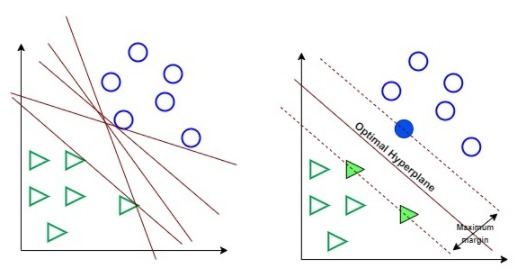

Sekarang, mari kita implementasikan SVM untuk analisis sentimen pada data IndoNLU. Berikut beberapa hal yang akan kita lakukan pada materi ini:

- Membaca Data
- Analisis Data
- Feature Engineering dengan TF-IDF
- Klasifikasi Sentimen dengan SVM
- Prediksi Sentimen

## Membaca Data

In [30]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

In [23]:
!git clone https://github.com/indobenchmark/indonlu

fatal: destination path 'indonlu' already exists and is not an empty directory.


In [24]:
data_train = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t')
data_train.head()

,"warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !",positive
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive


Jika outputnya diperhatikan kembali, data tidak memiliki header. Sehingga, kita perlu membuat header untuk data dan nama kolom sekaligus untuk membedakan antara konten teks dengan target label.

In [25]:
data_train = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t', names=["Teks", "Target"])
data_test = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv', sep='\t', names=["Teks", "Target"])

#mengambil 5 data teratas pada data train
data_train.head(5)

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


## Analisis Data

Pada tahap ini, kita akan mengecek berapa jumlah data_train dan data_test, komposisi label atau target sentimen pada data, dan menggunakan fungsi world cloud untuk melihat term yang muncul pada data.

In [26]:
# Melihat jumlah data pada data train dan test

print(data_train.shape)
print(data_test.shape)

(11000, 2)
(1260, 2)


Kita memiliki 11.000 data train dan 1.260 data test. Selanjutnya, untuk menghitung jumlah masing-masing variabel (positif, netral, dan negatif) pada kolom target data_train, eksekusi kode berikut.

In [27]:
# Menghitung jumlah data masing-masing variabel pada kolom Target
data_train['Target'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: Target, dtype: int64

<Axes: xlabel='Target'>

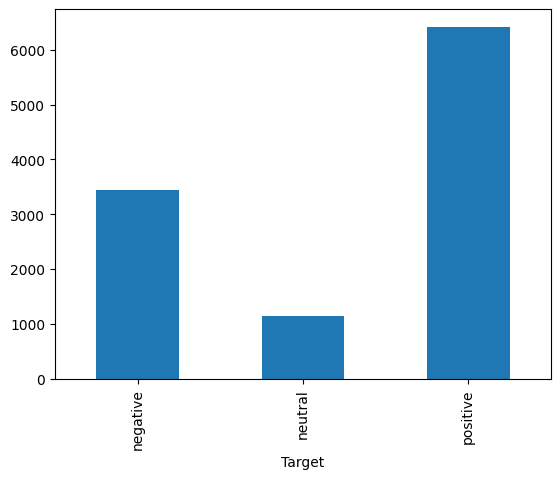

In [28]:
data_train.groupby('Target').size().plot(kind='bar')

Terlihat dari grafik kita memiliki dataset yang tidak seimbang (imbalanced dataset). Meskipun demikian, ini tidak menjadi masalah yang signifikan karena kita melatih ulasan berlabel sentimen satu per satu, menggunakan label sentimen masing-masing ulasan.

Selanjutnya, untuk mendapatkan pemahaman yang lebih mendalam pada data, kita ingin melihat panjang teks dalam data_train dan data_test. Seperti yang telah disebutkan pada materi sebelumnya, teks terpanjang pada data kita memiliki 92 urutan kata. Sekarang, mari kita lihat berapa panjang karakter string pada data.

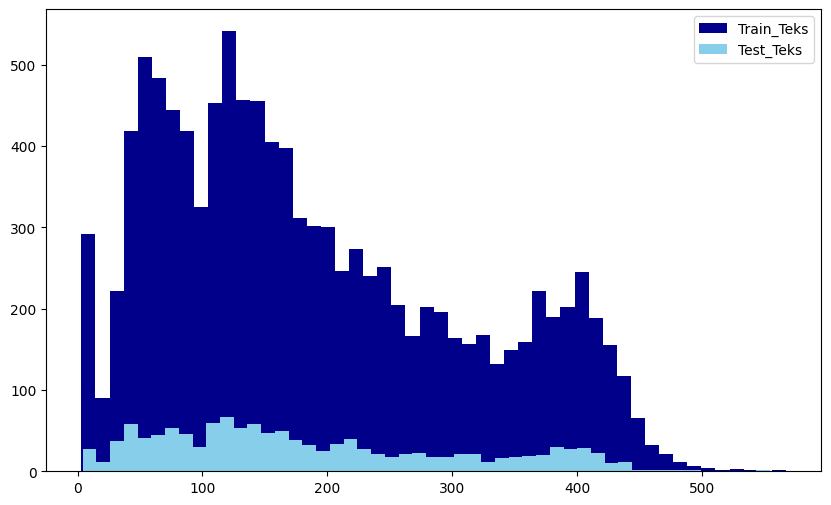

In [31]:
# Melihat panjang teks dalam data train dan data test

length_train = data_train['Teks'].str.len()
length_test = data_test['Teks'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="Train_Teks", color = "darkblue")
plt.hist(length_test, bins=50, label='Test_Teks', color = "skyblue")
plt.legend()

Untuk melihat sentimen pada data, kadang kita perlu melakukan visualisasi terhadap kata-kata dengan fungsi word cloud. Caranya adalah dengan mendefinisikan fungsinya terlebih dahulu. Kode berikut untuk membuat visualisasi wordcloud pada data_train. Jika Anda ingin melakukannya juga pada data_test, Anda tinggal mengubah sedikit kodenya.

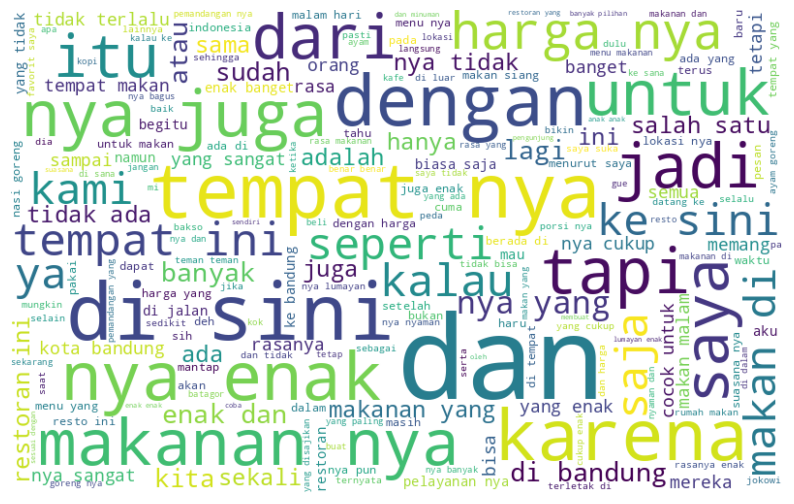

In [32]:
# Sentimen yang ada pada seluruh data train dapat dilihat dengan memahami kata yang umum dengan plot word cloud

def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in data_train['Teks']])
wordCloud(all_words)

Ini adalah kata-kata yang paling sering muncul dalam dokumen. Dari sana kita dapat mengenali beberapa kata kunci seperti enak, tapi, harga, tempat, dan makanan.

Selanjutnya, kita juga bisa melakukan plot word cloud khusus pada data dengan target sentimen tertentu. Misalnya jika kita ingin menargetkan sentimen negatif, jalankan kode berikut ini.

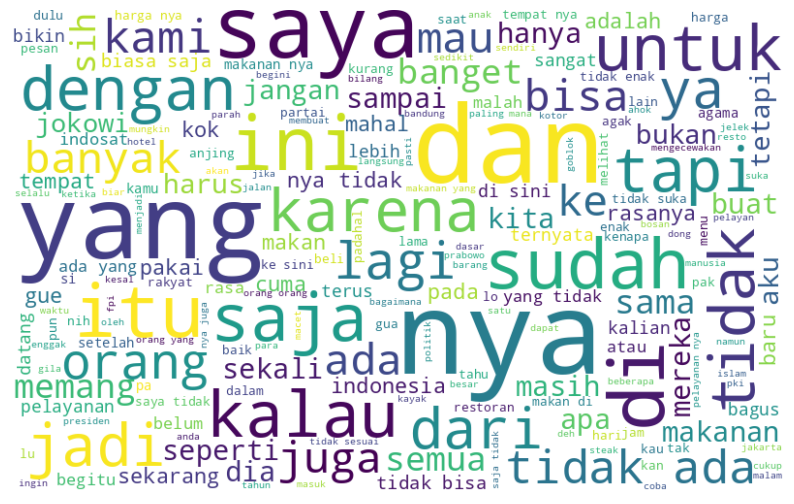

In [33]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'negative'])
wordCloud(negative_words)

Perhatikan beberapa kata menarik seperti “tidak”, “tapi”, dan “saja” sering muncul sebagai representasi dari sentimen negatif.

## Feature Engineering dengan TF-IDF
Fungsi tfidfvectorizer memiliki beberapa parameter, antara lain:

- min_df

Digunakan untuk menghilangkan term/istilah yang terlalu jarang muncul. Sebagai contoh, jika diset min_df = 0.01, artinya kita mengabaikan term yang muncul kurang dari 1% dalam teks. Jika diset min_df = 5, artinya kita mengabaikan term yang muncul dalam kurang dari 5 dokumen.

- max_df

Digunakan untuk menghilangkan term yang terlalu sering muncul, biasanya merupakan stop words yang telah kita bahas pada materi sebelumnya. Sebagai contoh, jika diset max_df=0.8, artinya kita mengabaikan term yang muncul lebih dari 80% dalam teks. Jika diset 25, artinya kita mengabaikan term yang muncul di lebih dari 25 dokumen.

- sublinear_tf

Berfungsi untuk melakukan scaling dan bernilai boolean dengan default false. Sublinear_tf=True akan mengubah vektor frekuensi menjadi bentuk logaritmik (1+log(tf)). Sehingga dapat menormalisasi bias terhadap teks yang panjang dan teks yang pendek.

- use_idf

Bernilai boolean dengan default True. Parameter ini memungkinkan kita untuk menggunakan Inverse Document Frequency (IDF). Hal ini berarti term yang terlalu sering muncul dalam teks akan diberi skor lebih sedikit dibanding term yang jarang muncul (hanya muncul pada teks yang spesifik saja).

Dalam proses vektorisasi ini, kita menggunakan dua metode yaitu:

- fit_transform

Metode ini mempelajari kosa kata dan Inverse Document Frequency (IDF) yang telah kita bahas sebelumnya. Ia memberikan nilai return berupa document-term matrix.

- transform

Metode ini mentransformasi dokumen ke dalam document-term matrix.

In [34]:
# Melakukan vektorisasi untuk mengekstrak fitur dengan TF-IDF
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(data_train['Teks'])
test_vectors = vectorizer.transform(data_test['Teks'])

## Klasifikasi Sentimen dengan Support Vector Machine

In [35]:
# melakukan klasifikasi dengan SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, data_train['Target'])
prediction_linear = classifier_linear.predict(test_vectors)

Untuk melihat metriks precision, recall, F1-score dan support pada model, kita tinggal memanggil fungsi classification_report dari library sklearn.

In [36]:
# print metriks
target_names = ['positive', 'negative', 'netral']
print(classification_report(data_test['Target'], prediction_linear, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.81      0.86      0.84       394
    negative       0.79      0.70      0.74       131
      netral       0.92      0.91      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.87      0.87      0.87      1260



Hasil metriknya memang tidak lebih bagus dari teknik Deep Learning sebelumnya, tapi masih cukup bagus dan nilainya konsisten. Selanjutnya, mari kita coba untuk memprediksi beberapa teks masukan.

## Prediksi Sentimen

In [37]:
teks = """Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita"""
teks_vector = vectorizer.transform([teks]) # vectorizing
print(classifier_linear.predict(teks_vector))

['positive']
